## Required libraries

In [48]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
import torchvision.transforms as transforms
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.utils.data
import os
import torchsummary
import torchvision.utils as vutils
from torch.utils.data import DataLoader, TensorDataset
import time
from scipy.linalg import sqrtm
from sklearn.metrics import r2_score
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import torchvision.models
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tabulate import tabulate
from PIL import Image, ImageFilter, ImageEnhance
from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

## Summarizing results

The performance metrics of the RoadDamageCNN and other classifiers indicate a comparative evaluation of model effectiveness for road damage detection. 
- The RoadDamageCNN achieves an **accuracy of 85%**, with balanced precision, recall, and F1-score values of 0.85, showcasing its potential as a lightweight and effective model.
- However,  **VGG-16 model ANN classifier**, in particular, stands out with the highest **accuracy of 95%**, alongside superior precision (0.96), recall (0.95), and F1-score (0.95), indicating its robustness in feature extraction and classification.
- **AlexNet and ResNet-50** also surpass the custom CNN in accuracy and other metrics, with **AlexNet achieving 90% accuracy** and balanced metrics across the board

Therefore, this comparative analysis highlights the trade-off between the simplicity and customization of RoadDamageCNN and the higher performance offered by complex pre-trained models, suggesting that model selection should consider specific project requirements, such as computational resources and real-time deployment constraints.

In [52]:
table_self = [
    ['Model', 'Accuracy(%)', 'Precision', 'Recall', 'F1-Score'],
    ['RoadDamageCNN', 85, 0.85, 0.85, 0.85]
]
table_ANN = [
    ['Model', 'Accuracy(%)', 'Precision', 'Recall', 'F1-Score'],
    ['ResNet-50', 85, 0.85, 0.85, 0.85],
    ['VGG-16', 95, 0.96, 0.95, 0.95],
    ['AlexNet', 88, 0.89, 0.88, 0.87]
]
table_CNN = [
    ['Model', 'Accuracy(%)', 'Precision', 'Recall', 'F1-Score'],
    ['ResNet-50', 88, 0.88, 0.88, 0.87],
    ['VGG-16', 93, 0.94, 0.93, 0.92],
    ['AlexNet', 90, 0.93, 0.90, 0.90]
]

# Titles for each table
title_self = "Performance Summary with RoadDamageCNN"
title_ANN = "Performance Summary with ANN Classifier"
title_CNN = "Performance Summary with CNN Classifier"

print(title_self)
print(tabulate(table_self, headers='firstrow', tablefmt='grid'))
print("\n" + "="*60 + "\n")  # Separator between tables

print(title_ANN)
print(tabulate(table_ANN, headers='firstrow', tablefmt='grid'))
print("\n" + "="*60 + "\n")  # Separator between tables

print(title_CNN)
print(tabulate(table_CNN, headers='firstrow', tablefmt='grid'))


Performance Summary with RoadDamageCNN
+---------------+---------------+-------------+----------+------------+
| Model         |   Accuracy(%) |   Precision |   Recall |   F1-Score |
+===============+===============+=============+==========+============+
| RoadDamageCNN |            85 |        0.85 |     0.85 |       0.85 |
+---------------+---------------+-------------+----------+------------+


Performance Summary with ANN Classifier
+-----------+---------------+-------------+----------+------------+
| Model     |   Accuracy(%) |   Precision |   Recall |   F1-Score |
+===========+===============+=============+==========+============+
| ResNet-50 |            85 |        0.85 |     0.85 |       0.85 |
+-----------+---------------+-------------+----------+------------+
| VGG-16    |            95 |        0.96 |     0.95 |       0.95 |
+-----------+---------------+-------------+----------+------------+
| AlexNet   |            88 |        0.89 |     0.88 |       0.87 |
+-----------+--

## Comparison of our model with previous works

The comparison of our work with previous studies highlights significant improvements in dataset size, damage classification scope, and model performance. 
  -  Zhang et al. [1] achieved a recall of 0.92 and an F1-score of 0.89 using a CNN, our custom CNN model (RoadDamageCNN) achieved balanced metrics across accuracy, precision, recall, and F1-score, each at 0.85, despite handling a more complex classification problem
  -  Furthermore, our implementation of VGG-16 achieved superior results, with an accuracy of 95% and an F1-score of 0.95, outperforming Silva and Lucena's [2] results on a smaller dataset.
  -  Similarly, our adaptation of AlexNet achieved an accuracy of 90% and an F1-score of 0.9, demonstrating improved generalizability for multi-class classification tasks.

**These comparisons underscore the scalability and robustness of our approach in addressing road damage detection challenges**

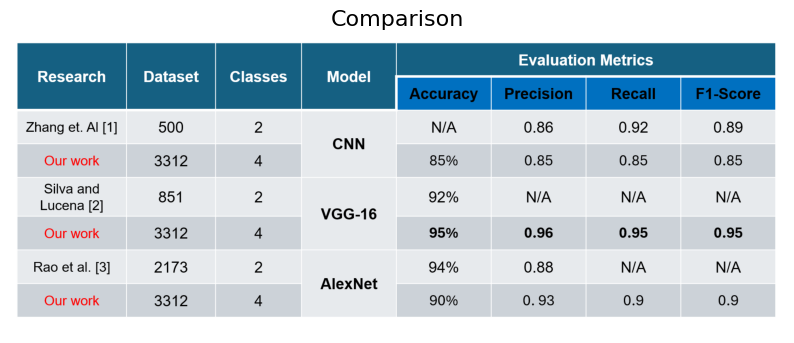

In [45]:
img_path = '/workspace/data/ResultsComparison.png'
img = mpimg.imread(img_path)
plt.figure(figsize=(10, 8))  
plt.imshow(img)
plt.axis('off')  
plt.title("Comparison", fontsize=16, loc='center')
plt.show()

In [3]:
rstate = 999
random.seed(rstate)
#libraries relying on NumPy
np.random.seed(rstate)
#for both CPU and CUDA devices
torch.manual_seed(rstate)
# If using GPU, set the seed for the CUDA backend to ensure reproducibility
if torch.cuda.is_available():
    torch.cuda.manual_seed(rstate)
    torch.cuda.manual_seed_all(rstate)  # Set seed for all available GPUs
g_cuda = torch.Generator(device='cuda').manual_seed(rstate)

# To make convolution operations deterministic, which can affect reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('device =', device)

device = cuda


# Dataset and Preprocessing

This section of the project focuses on data preparation and transformation for training, validation, and testing of the road damage detection model.
- Training, validation, and testing data were acquired from Kaggle (https://www.kaggle.com/datasets/prudhvignv/road-damage-classification-and-assessment)
- The dataset is organized into three main directories: training, validation, and testing, each containing subfolders representing the four damage condition **classes: good, satisfactory, poor, and very_poor**.
- The dataset initially contained a total of 2,074 images across all classes and the distribution of image data was similar across all classes.
- The training set consists of 2952 images, while the validation and test sets comprise 320 and 40 images, respectively.
- To ensure uniformity and compatibility with the model, all images were resized to 244x244 pixels.
- To expand the dataset and enhance feature recognition, various data augmentation techniques were applied to the existing images. These included **blurring 20% of the images, flipping 20% along the vertical axis, brightening 10%, and darkening 10%** of the images.

## Data loading

In [5]:
# defining training, validation and test data directories
# Using local GPUs for trqaining the model
data_dir = '/workspace/data/augmented_data_images'
train_dir = os.path.join(data_dir, 'train/')
val_dir = os.path.join(data_dir, 'validation/')
test_dir = os.path.join(data_dir, 'test/')

# classes are folders in each directory with their corresponding names
classes = ['good','satisfactory', 'poor', 'very_poor']

## Transforming data

In [6]:
data_transform = transforms.Compose([transforms.CenterCrop(224),transforms.Resize((224,224)),
                                     transforms.ToTensor()])
train_data = datasets.ImageFolder(train_dir, transform =data_transform )
validation_data = datasets.ImageFolder(val_dir, transform = data_transform)
test_data = datasets.ImageFolder(test_dir, transform = data_transform)
# print out the data stats
print('Number training images: ', len(train_data))
print('Number validation images: ', len(validation_data))
print('Number test images: ', len(test_data))

Number training images:  2952
Number validation images:  320
Number test images:  40


## Data augmentation

In [4]:
source_folder = '/workspace/data/road_dataset'
output_folder = '/workspace/data/augmented_data_images'
os.makedirs(output_folder, exist_ok=True)

subfolders = ['good', 'poor', 'satisfactory', 'very_poor']
resize_dimensions = (244, 244)
blur_percentage = 0.20
brighten_percentage = 0.10
darken_percentage = 0.10
flip_percentage = 0.20

sample_images = {'original': None, 'blurred': None, 'brightened': None, 'darkened': None, 'flipped': None}

for subfolder in subfolders:
    input_path = os.path.join(source_folder, subfolder)
    output_path = os.path.join(output_folder, subfolder)
    os.makedirs(output_path, exist_ok=True)
    images = [f for f in os.listdir(input_path) if f.lower().endswith(('png', 'jpg', 'jpeg', 'bmp', 'gif'))]
    
   
    num_blur_images = int(len(images) * blur_percentage)
    num_brighten_images = int(len(images) * brighten_percentage)
    num_darken_images = int(len(images) * darken_percentage)
    num_flip_images = int(len(images) * flip_percentage)
    
    blur_images = random.sample(images, num_blur_images)
    remaining_images = list(set(images) - set(blur_images))
    
    brighten_images = random.sample(remaining_images, num_brighten_images)
    remaining_images = list(set(remaining_images) - set(brighten_images))
    
    darken_images = random.sample(remaining_images, num_darken_images)
    remaining_images = list(set(remaining_images) - set(darken_images))
    
    flip_images = random.sample(remaining_images, num_flip_images)

    for filename in images:
        img_path = os.path.join(input_path, filename)
        
        with Image.open(img_path) as img:
            #convert to RGB if image has transparency
            if img.mode in ('RGBA', 'LA') or (img.mode == 'P' and 'transparency' in img.info):
                img = img.convert('RGB')

            #resize images
            resized_img = img.resize(resize_dimensions)

            resized_filename = os.path.join(output_path, filename)
            if filename.lower().endswith(('png', 'bmp', 'gif')):
                resized_filename = os.path.splitext(resized_filename)[0] + '.jpg'
            resized_img.save(resized_filename, 'JPEG')
            
            if sample_images['original'] is None:
                sample_images['original'] = resized_img

            #apply blur
            if filename in blur_images:
                blurred_img = resized_img.filter(ImageFilter.GaussianBlur(2))
                blurred_filename = os.path.join(output_path, f"blurred_{filename}")
                blurred_img.save(blurred_filename, 'JPEG')
                if sample_images['blurred'] is None:
                    sample_images['blurred'] = blurred_img

            #increase brightness
            if filename in brighten_images:
                enhancer = ImageEnhance.Brightness(resized_img)
                brightened_img = enhancer.enhance(1.2)
                brightened_filename = os.path.join(output_path, f"brightened_{filename}")
                brightened_img.save(brightened_filename, 'JPEG')
                if sample_images['brightened'] is None:
                    sample_images['brightened'] = brightened_img

            #decrease brightness
            if filename in darken_images:
                enhancer = ImageEnhance.Brightness(resized_img)
                darkened_img = enhancer.enhance(0.8)
                darkened_filename = os.path.join(output_path, f"darkened_{filename}")
                darkened_img.save(darkened_filename, 'JPEG')
                if sample_images['darkened'] is None:
                    sample_images['darkened'] = darkened_img

            #flip about vertical access
            if filename in flip_images:
                flipped_img = resized_img.transpose(Image.FLIP_LEFT_RIGHT)
                flipped_filename = os.path.join(output_path, f"flipped_{filename}")
                flipped_img.save(flipped_filename, 'JPEG')
                if sample_images['flipped'] is None:
                    sample_images['flipped'] = flipped_img

#image visualization just to check outpupt
fig, axs = plt.subplots(1, 5, figsize=(20, 4))
steps = ['original', 'blurred', 'brightened', 'darkened', 'flipped']
titles = ['Original Resized', 'Blurred', 'Brightened', 'Darkened', 'Flipped']

for i, step in enumerate(steps):
    axs[i].imshow(sample_images[step])
    axs[i].set_title(titles[i])
    axs[i].axis('off')

plt.show()

source_file_count = sum(len(files) for _, _, files in os.walk(source_folder))
expected_output_file_count = source_file_count * (1 + 0.2 + 0.2 + 0.1 + 0.1)
actual_output_file_count = sum(len(files) for _, _, files in os.walk(output_folder))

# print(f"Total number of files in '{source_folder}': {source_file_count}")
# print(f"Expected number of files in '{output_folder}': {int(expected_output_file_count)}")
# print(f"Actual number of files in '{output_folder}': {actual_output_file_count}")

## Dataloader parameters

In [7]:
# define dataloader parameters
batch_size  = 64
num_workers = 0

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                           num_workers=num_workers, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size,
                                          num_workers=num_workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                          num_workers=num_workers, shuffle=True)

In [8]:
dataiter       = iter(train_loader)
images, labels = next(dataiter)
print("Training samples shape:", images.shape)
validation_iter         = iter(validation_loader)
val_images, val_labels  = next(validation_iter)
print("Validation samples shape:", val_images.shape)
test_iter               = iter(test_loader)
test_images,test_labels = next(test_iter)
print("Test samples shape:", test_images.shape)

Training samples shape: torch.Size([64, 3, 224, 224])
Validation samples shape: torch.Size([64, 3, 224, 224])
Test samples shape: torch.Size([40, 3, 224, 224])


## Visualizing data

A selection of the training data used for model training is presented below:

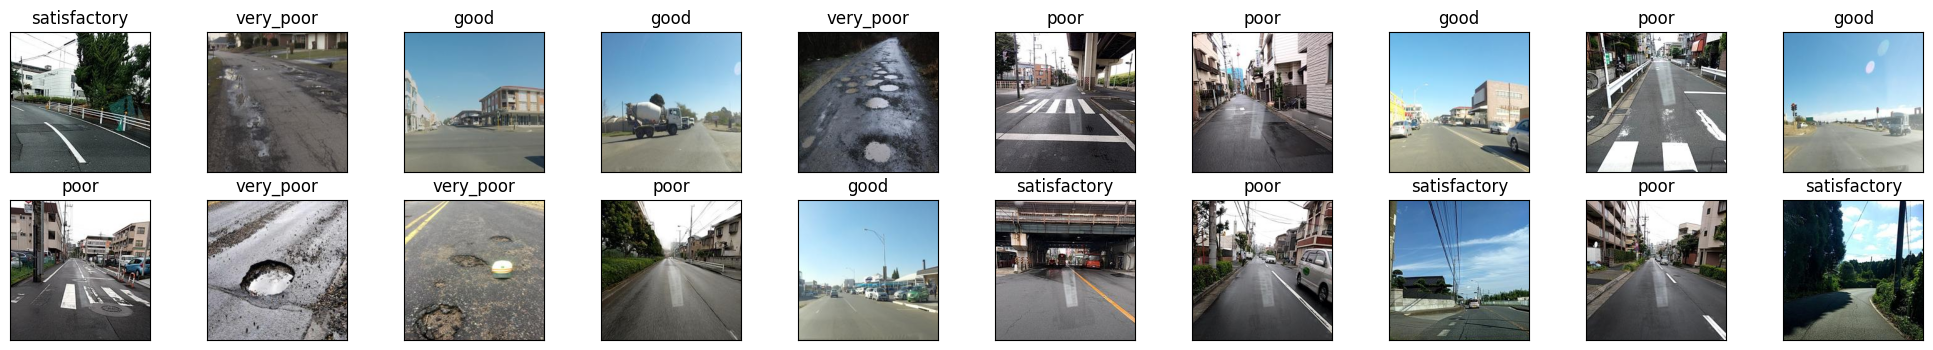

In [9]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy() # convert images to numpy for display

# plotting the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

## Training part

In [10]:
def get_accuracy(model, data_loader):
    correct = 0
    total = 0
    for imgs, labels in data_loader:

        #############################################
        #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
            imgs = imgs.cuda()
            labels = labels.cuda()
        #############################################
        output = model(imgs)

        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

In [11]:
def get_model_name(name, batch_size, learning_rate, epoch):
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

In [12]:
def evaluate(model, data_loader):
    criterion = nn.CrossEntropyLoss()
    correct = 0
    total = 0
    total_loss=0
    n=0
    for imgs, labels in data_loader:
        #############################################
        #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
            imgs = imgs.cuda()
            labels = labels.cuda()
        #############################################
        output = model(imgs)
        loss = criterion(output, labels)
        total_loss += (loss.item())
        n += 1
        #selecting index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    loss=float(total_loss) / (len(data_loader.sampler))
    accuracy = correct / total
    return accuracy, loss

In [13]:
def train(model, train_data, valid_data, batch_size, lr, num_epochs):
    
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                           num_workers=0, shuffle=True)
    val_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, 
                                          num_workers=0, shuffle=True)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

    # Adding a learning rate scheduler for plateau condition
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

    iters, train_loss, train_acc, val_acc, val_Loss, Epochs = [], [], [], [], [], []

    n = 0  # Number of iterations
    for epoch in range(num_epochs):
        n = 0
        total_train_loss = 0.0
        model.train()

        for imgs, labels in iter(train_loader):
            # To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
                imgs = imgs.cuda()
                labels = labels.cuda()
            
            # Forward pass
            out = model(imgs)
            loss = criterion(out, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            # Training loss for each batch
            total_train_loss += loss.item()
            n += 1

        # Average training loss
        Train_Loss = float(total_train_loss) / (len(train_loader.sampler))
        train_loss.append(Train_Loss)
        Epochs.append(epoch + 1)

        # Calculate training accuracy
        train_Acc = get_accuracy(model, train_loader)
        train_acc.append(train_Acc)

        # Set the model to evaluation mode for validation
        model.eval()
        val_Acc, val_loss = evaluate(model, val_loader)
        val_Loss.append(val_loss)
        val_acc.append(val_Acc)

        # Step the scheduler based on validation loss
        scheduler.step(val_loss)

        # printing last 10 epochs loss and accuracy for both Train and validation
        if epoch >= num_epochs - 10:
            print(f"Epoch {epoch + 1}: Train accuracy = {train_Acc:.2f}, Train loss = {Train_Loss:.4f}, "
                  f"Validation accuracy = {val_Acc:.2f}, Validation loss = {val_loss:.4f}")

    # Saving the model checkpoint to a file
    model_path = get_model_name(model.name, batch_size, lr, num_epochs - 1)
    torch.save(model.state_dict(), model_path)

    # Plotting the loss curves for training and validation
    plt.title("Training and Validation Loss")
    plt.plot(Epochs, train_loss, label="Train Loss")
    plt.plot(Epochs, val_Loss, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

    # Plotting the accuracy curves for training and validation
    plt.title("Training and Validation Accuracy")
    plt.plot(Epochs, train_acc, label="Train Accuracy")
    plt.plot(Epochs, val_acc, label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

## CNN model detecting Road damages without Transfer Learning

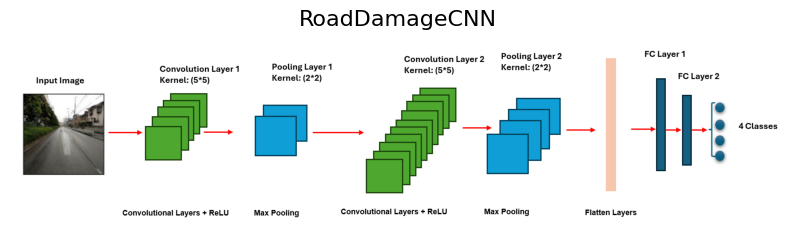

In [39]:
img_path = '/workspace/data/RoadDamageCNN.png'
img = mpimg.imread(img_path)
plt.figure(figsize=(10, 8))  
plt.imshow(img)
plt.axis('off')  
plt.title("RoadDamageCNN", fontsize=16, loc='center')
plt.show()

In [57]:
class RoadDamageCNN(nn.Module):
    def __init__(self):
        super(RoadDamageCNN, self).__init__()
        self.name = 'RoadDamageCNN'

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, stride=1, padding=2)
        #self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=2)
        #self.bn2 = nn.BatchNorm2d(64)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.dropout = nn.Dropout(p=0.5)

        self.fc1 = nn.Linear(64 * 56 * 56, 256)  
        self.fc2 = nn.Linear(256, 4)

    def forward(self, x):
        #x = F.relu(self.bn1(self.conv1(x)))
        x =  F.relu(self.conv1(x))
        x = self.pool(x)

        #x = F.relu(self.bn2(self.conv2(x)))
        x =  F.relu(self.conv2(x))
        x = self.pool(x)

        x = x.view(x.size(0), -1)

        x = F.relu(self.fc1(x))
        x = self.dropout(x)

        x = self.fc2(x)

        return x

model = RoadDamageCNN()
print(model)

RoadDamageCNN(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=200704, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=4, bias=True)
)


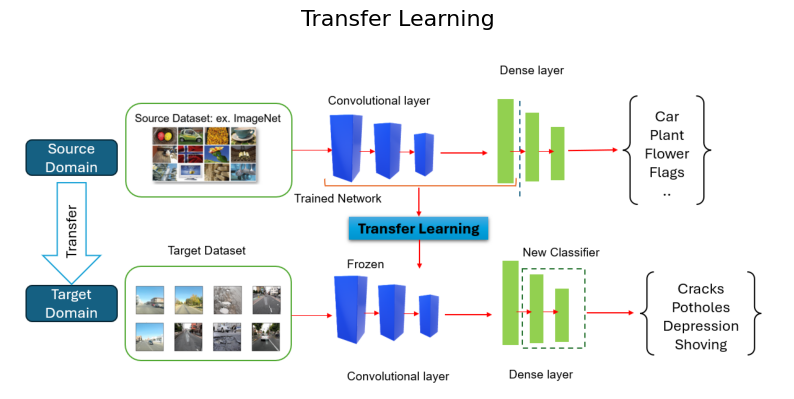

In [42]:
img_path = '/workspace/data/Transfer Learning.png'
img = mpimg.imread(img_path)
plt.figure(figsize=(10, 8))  
plt.imshow(img)
plt.axis('off')  
plt.title("Transfer Learning", fontsize=16, loc='center')
plt.show()

## Classifier used for Transfer Learning models

In [58]:
class Classifier_ANN_Alexnet(nn.Module):
    def __init__(self):
        super(Classifier_ANN_Alexnet, self).__init__()
        self.name = 'Classifier_ANN_Alexnet'

        self.fc1 = nn.Linear(256 * 6 * 6, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256, 4)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten feature data
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.fc3(x)
        return x

class Classifier_ANN_vgg16(nn.Module):
    def __init__(self):
        super(Classifier_ANN_vgg16, self).__init__()
        self.name = 'Classifier_ANN_vgg16'

        self.fc1 = nn.Linear(512 * 7 * 7, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256, 4)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten feature data
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.fc3(x)
        return x

class Classifier_ANN_resnet50(nn.Module):
    def __init__(self):
        super(Classifier_ANN_resnet50, self).__init__()
        self.name = 'Classifier_ANN_resnet50'

        self.fc1 = nn.Linear(2048 * 1 * 1, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256, 4)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten feature data
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.fc3(x)
        return x

class Classifier_CNN_Alexnet(nn.Module):
    def __init__(self):
        super(Classifier_CNN_Alexnet, self).__init__()
        self.name = 'Classifier_CNN_Alexnet'

        self.conv1 = nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(128)
        self.conv2 = nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(64 * 6 * 6, 256)
        self.fc2 = nn.Linear(256, 4)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Flatten feature data
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class Classifier_CNN_vgg16(nn.Module):
    def __init__(self):
        super(Classifier_CNN_vgg16, self).__init__()
        self.name = 'Classifier_CNN_vgg16'

        self.conv1 = nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(256)
        self.conv2 = nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.fc1 = nn.Linear(128 * 7 * 7, 256)
        self.fc2 = nn.Linear(256, 4)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Flatten feature data
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class Classifier_CNN_resnet50(nn.Module):
    def __init__(self):
        super(Classifier_CNN_resnet50, self).__init__()
        self.name = 'Classifier_CNN_resnet50'

        self.conv1 = nn.Conv2d(2048, 1024, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(1024)
        self.conv2 = nn.Conv2d(1024, 512, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(512)
        self.fc1 = nn.Linear(512 * 1 * 1, 256)
        self.fc2 = nn.Linear(256, 4)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Flatten feature data
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

## Importing AlexNet pre-trained model

In [16]:
alexnet = torchvision.models.alexnet(pretrained=True)
dataiter_alexnet = iter(train_loader)
images_alexnet, labels_alexnet = next(dataiter_alexnet)
features_alexnet = alexnet.features(images_alexnet)
features_alexnet.shape

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


torch.Size([64, 256, 6, 6])

## Importing VGG-16 pre-trained model

In [17]:
vgg16 = torchvision.models.vgg16(pretrained=True)
dataiter_vgg16 = iter(train_loader)
images_vgg16, labels_vgg16 = next(dataiter_vgg16)
features_vgg16 = vgg16.features(images_vgg16)
features_vgg16.shape

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


torch.Size([64, 512, 7, 7])

## Importing ResNet-50 pre-trained model

In [18]:
resnet50 = torchvision.models.resnet50(pretrained=True)
resnet50_feature_extract = torch.nn.Sequential(*(list(resnet50.children())[:-1]))  # except the fully connected layer
dataiter_resnet50 = iter(train_loader)
images_resnet50, labels_resnet50 = next(dataiter_resnet50)
features_resnet50 = resnet50_feature_extract(images_resnet50)
features_resnet50.shape

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


torch.Size([64, 2048, 1, 1])

## Freezing pre-trained model weights

In [19]:
# Freezing model weights as we want to treain the model with only last fully-connected layer
for param in alexnet.parameters():
    param.requires_grad = False

for param in vgg16.parameters():
    param.requires_grad = False

for param in resnet50.parameters():
    param.requires_grad = False

## Creating new dataset from AlexNet features

In [20]:
# saving the out put features from the alexnet and creating a new dataset with these features
def Extract_feature_image_alexnet(data_loader):
    feature_tensor=torch.empty([0,256, 6, 6])
    label=torch.empty([0], dtype = torch.long)
    for imgs, labels in iter(data_loader):
        with torch.no_grad():
            features = alexnet.features(imgs)
        feature_tensor=torch.cat((feature_tensor, features), 0)
        label=torch.cat((label, labels), 0)
    return torch.utils.data.TensorDataset(feature_tensor, label)

data_Train_alexnet      = Extract_feature_image_alexnet(train_loader)
data_Validation_alexnet = Extract_feature_image_alexnet(validation_loader)
data_test_alexnet       = Extract_feature_image_alexnet(test_loader)

## Creating new dataset from vgg16 features

In [21]:
def Extract_feature_image_vgg16(data_loader):
    feature_tensor=torch.empty([0 ,512, 7, 7])
    label=torch.empty([0], dtype = torch.long)
    for imgs, labels in iter(data_loader):
        with torch.no_grad():
            features = vgg16.features(imgs)
        feature_tensor=torch.cat((feature_tensor, features), 0)
        label=torch.cat((label, labels), 0)
    return torch.utils.data.TensorDataset(feature_tensor, label)

data_Train_vgg16      = Extract_feature_image_vgg16(train_loader)
data_Validation_vgg16 = Extract_feature_image_vgg16(validation_loader)
data_test_vgg16       = Extract_feature_image_vgg16(test_loader)

## Creating new dataset from resnet50 features

In [22]:
def Extract_feature_image_resnet50(data_loader):
    feature_tensor=torch.empty([0 ,2048, 1, 1])
    label=torch.empty([0], dtype = torch.long)
    for imgs, labels in iter(data_loader):
        resnet50_feature_extract = torch.nn.Sequential(*(list(resnet50.children())[:-1]))  # except the fully connected layer
        with torch.no_grad():
            features = resnet50_feature_extract(imgs)
        feature_tensor=torch.cat((feature_tensor, features), 0)
        label=torch.cat((label, labels), 0)
    return torch.utils.data.TensorDataset(feature_tensor, label)

data_Train_resnet50      = Extract_feature_image_resnet50(train_loader)
data_Validation_resnet50 = Extract_feature_image_resnet50(validation_loader)
data_test_resnet50       = Extract_feature_image_resnet50(test_loader)

## Train with AlexNet

CUDA is available!  Training on GPU ...


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 91: Train accuracy = 1.00, Train loss = 0.0005, Validation accuracy = 0.97, Validation loss = 0.0034
Epoch 92: Train accuracy = 1.00, Train loss = 0.0005, Validation accuracy = 0.97, Validation loss = 0.0034
Epoch 93: Train accuracy = 1.00, Train loss = 0.0005, Validation accuracy = 0.97, Validation loss = 0.0035
Epoch 94: Train accuracy = 1.00, Train loss = 0.0005, Validation accuracy = 0.97, Validation loss = 0.0033
Epoch 95: Train accuracy = 1.00, Train loss = 0.0005, Validation accuracy = 0.96, Validation loss = 0.0037
Epoch 96: Train accuracy = 1.00, Train loss = 0.0005, Validation accuracy = 0.97, Validation loss = 0.0034
Epoch 97: Train accuracy = 1.00, Train loss = 0.0005, Validation accuracy = 0.97, Validation loss = 0.0036
Epoch 98: Train accuracy = 1.00, Train loss = 0.0006, Validation accuracy = 0.96, Validation loss = 0.0038
Epoch 99: Train accuracy = 1.00, Train loss = 0.0005, Validation accuracy = 0.96, Validation loss = 0.0036
Epoch 100: Train accuracy = 1.00, Tra

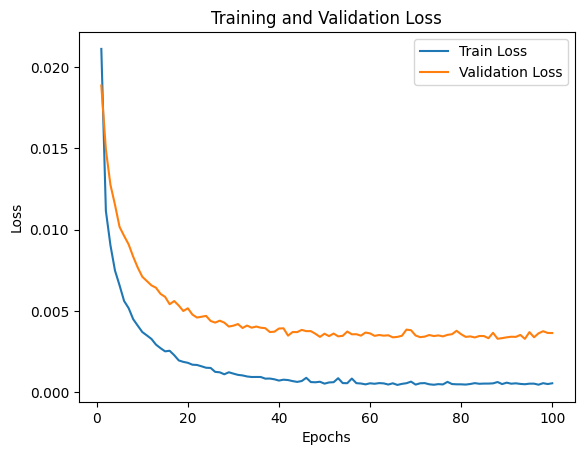

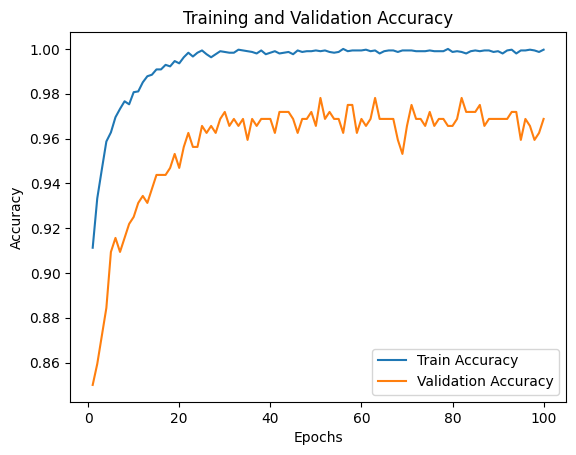

Final Training Accuracy: 0.9996612466124661
Final Validation Accuracy: 0.96875


In [23]:
use_cuda = True
model_alexnet_ANN=Classifier_ANN_Alexnet()

if use_cuda and torch.cuda.is_available():
    model_alexnet_ANN.cuda()
    print('CUDA is available!  Training on GPU ...')
else:
    print('CUDA is not available.  Training on CPU ...')

batch_size  = 32
num_workers = 0
train(model_alexnet_ANN, data_Train_alexnet, data_Validation_alexnet, batch_size=32, lr=0.0001, num_epochs=100)

CUDA is available!  Training on GPU ...
Epoch 91: Train accuracy = 1.00, Train loss = 0.0004, Validation accuracy = 0.94, Validation loss = 0.0045
Epoch 92: Train accuracy = 1.00, Train loss = 0.0004, Validation accuracy = 0.95, Validation loss = 0.0043
Epoch 93: Train accuracy = 1.00, Train loss = 0.0004, Validation accuracy = 0.95, Validation loss = 0.0042
Epoch 94: Train accuracy = 1.00, Train loss = 0.0004, Validation accuracy = 0.95, Validation loss = 0.0043
Epoch 95: Train accuracy = 1.00, Train loss = 0.0004, Validation accuracy = 0.95, Validation loss = 0.0042
Epoch 96: Train accuracy = 1.00, Train loss = 0.0004, Validation accuracy = 0.95, Validation loss = 0.0043
Epoch 97: Train accuracy = 1.00, Train loss = 0.0004, Validation accuracy = 0.95, Validation loss = 0.0043
Epoch 98: Train accuracy = 1.00, Train loss = 0.0004, Validation accuracy = 0.95, Validation loss = 0.0043
Epoch 99: Train accuracy = 1.00, Train loss = 0.0004, Validation accuracy = 0.95, Validation loss = 0.00

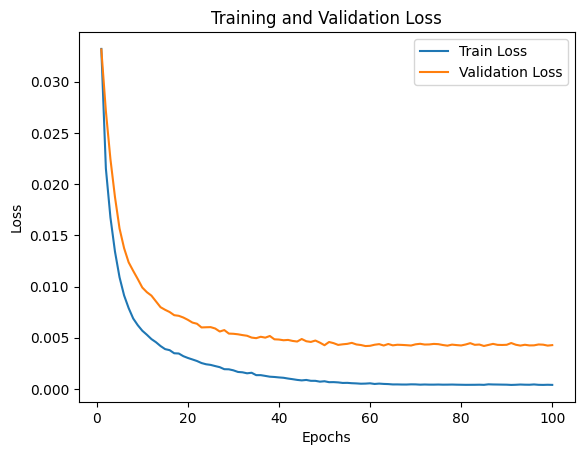

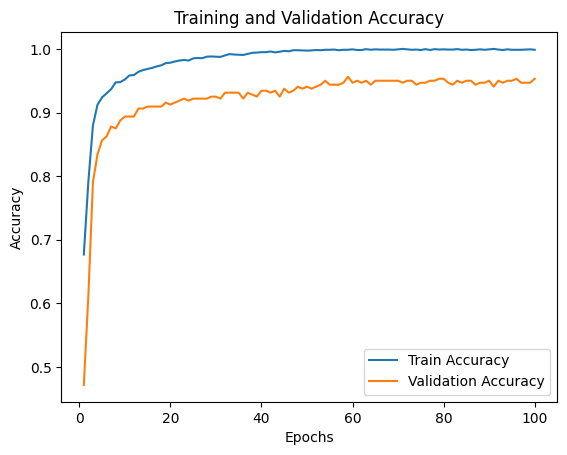

Final Training Accuracy: 0.9986449864498645
Final Validation Accuracy: 0.953125


In [24]:
use_cuda = True
model_alexnet_CNN=Classifier_CNN_Alexnet()

if use_cuda and torch.cuda.is_available():
    model_alexnet_CNN.cuda()
    print('CUDA is available!  Training on GPU ...')
else:
    print('CUDA is not available.  Training on CPU ...')

batch_size  = 32
num_workers = 0
train(model_alexnet_CNN, data_Train_alexnet, data_Validation_alexnet, batch_size=32, lr=0.0001, num_epochs=100)

## Train with vgg16

CUDA is available!  Training on GPU ...
Epoch 91: Train accuracy = 1.00, Train loss = 0.0007, Validation accuracy = 0.95, Validation loss = 0.0051
Epoch 92: Train accuracy = 1.00, Train loss = 0.0007, Validation accuracy = 0.96, Validation loss = 0.0051
Epoch 93: Train accuracy = 1.00, Train loss = 0.0006, Validation accuracy = 0.96, Validation loss = 0.0050
Epoch 94: Train accuracy = 1.00, Train loss = 0.0006, Validation accuracy = 0.96, Validation loss = 0.0049
Epoch 95: Train accuracy = 1.00, Train loss = 0.0006, Validation accuracy = 0.94, Validation loss = 0.0055
Epoch 96: Train accuracy = 1.00, Train loss = 0.0006, Validation accuracy = 0.96, Validation loss = 0.0048
Epoch 97: Train accuracy = 1.00, Train loss = 0.0007, Validation accuracy = 0.95, Validation loss = 0.0050
Epoch 98: Train accuracy = 1.00, Train loss = 0.0006, Validation accuracy = 0.95, Validation loss = 0.0051
Epoch 99: Train accuracy = 1.00, Train loss = 0.0006, Validation accuracy = 0.95, Validation loss = 0.00

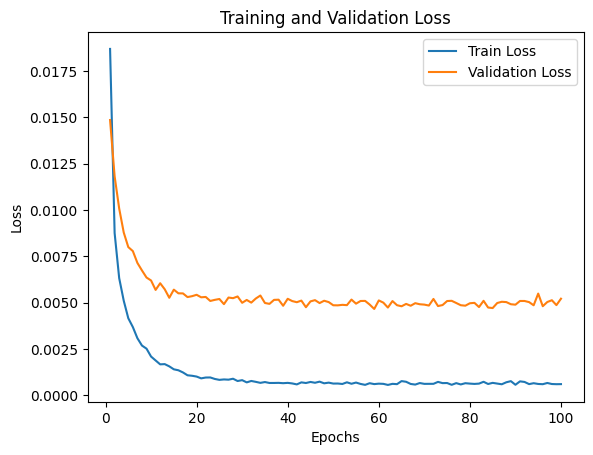

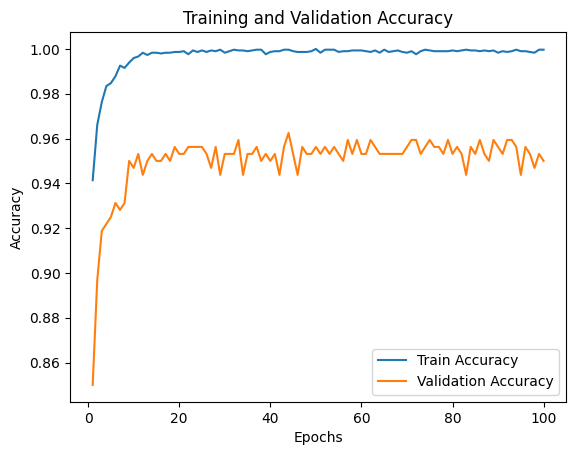

Final Training Accuracy: 0.9996612466124661
Final Validation Accuracy: 0.95


In [25]:
use_cuda = True
model_vgg16_ANN=Classifier_ANN_vgg16()

if use_cuda and torch.cuda.is_available():
    model_vgg16_ANN.cuda()
    print('CUDA is available!  Training on GPU ...')
else:
    print('CUDA is not available.  Training on CPU ...')

batch_size  = 32
num_workers = 0
train(model_vgg16_ANN, data_Train_vgg16, data_Validation_vgg16, batch_size=32, lr=0.0001, num_epochs=100)

CUDA is available!  Training on GPU ...
Epoch 91: Train accuracy = 1.00, Train loss = 0.0003, Validation accuracy = 0.95, Validation loss = 0.0049
Epoch 92: Train accuracy = 1.00, Train loss = 0.0003, Validation accuracy = 0.95, Validation loss = 0.0050
Epoch 93: Train accuracy = 1.00, Train loss = 0.0003, Validation accuracy = 0.95, Validation loss = 0.0050
Epoch 94: Train accuracy = 1.00, Train loss = 0.0003, Validation accuracy = 0.95, Validation loss = 0.0049
Epoch 95: Train accuracy = 1.00, Train loss = 0.0003, Validation accuracy = 0.95, Validation loss = 0.0050
Epoch 96: Train accuracy = 1.00, Train loss = 0.0003, Validation accuracy = 0.95, Validation loss = 0.0050
Epoch 97: Train accuracy = 1.00, Train loss = 0.0003, Validation accuracy = 0.95, Validation loss = 0.0049
Epoch 98: Train accuracy = 1.00, Train loss = 0.0003, Validation accuracy = 0.95, Validation loss = 0.0050
Epoch 99: Train accuracy = 1.00, Train loss = 0.0003, Validation accuracy = 0.95, Validation loss = 0.00

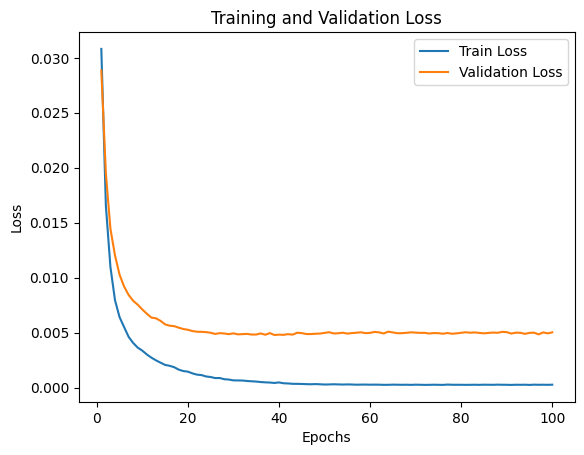

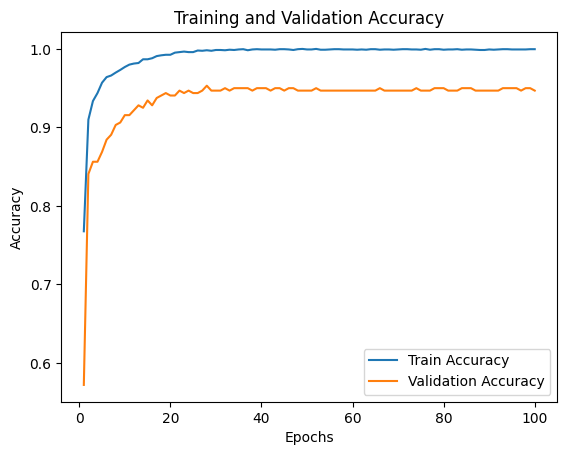

Final Training Accuracy: 0.9996612466124661
Final Validation Accuracy: 0.946875


In [26]:
use_cuda = True
model_vgg16_CNN=Classifier_CNN_vgg16()

if use_cuda and torch.cuda.is_available():
    model_vgg16_CNN.cuda()
    print('CUDA is available!  Training on GPU ...')
else:
    print('CUDA is not available.  Training on CPU ...')

batch_size  = 32
num_workers = 0
train(model_vgg16_CNN, data_Train_vgg16, data_Validation_vgg16, batch_size=32, lr=0.0001, num_epochs=100)

## Train with resnet50

CUDA is available!  Training on GPU ...
Epoch 91: Train accuracy = 1.00, Train loss = 0.0009, Validation accuracy = 0.94, Validation loss = 0.0070
Epoch 92: Train accuracy = 1.00, Train loss = 0.0010, Validation accuracy = 0.95, Validation loss = 0.0062
Epoch 93: Train accuracy = 1.00, Train loss = 0.0010, Validation accuracy = 0.95, Validation loss = 0.0060
Epoch 94: Train accuracy = 1.00, Train loss = 0.0011, Validation accuracy = 0.94, Validation loss = 0.0065
Epoch 95: Train accuracy = 1.00, Train loss = 0.0011, Validation accuracy = 0.95, Validation loss = 0.0062
Epoch 96: Train accuracy = 1.00, Train loss = 0.0010, Validation accuracy = 0.94, Validation loss = 0.0067
Epoch 97: Train accuracy = 1.00, Train loss = 0.0010, Validation accuracy = 0.93, Validation loss = 0.0070
Epoch 98: Train accuracy = 1.00, Train loss = 0.0010, Validation accuracy = 0.95, Validation loss = 0.0061
Epoch 99: Train accuracy = 1.00, Train loss = 0.0012, Validation accuracy = 0.94, Validation loss = 0.00

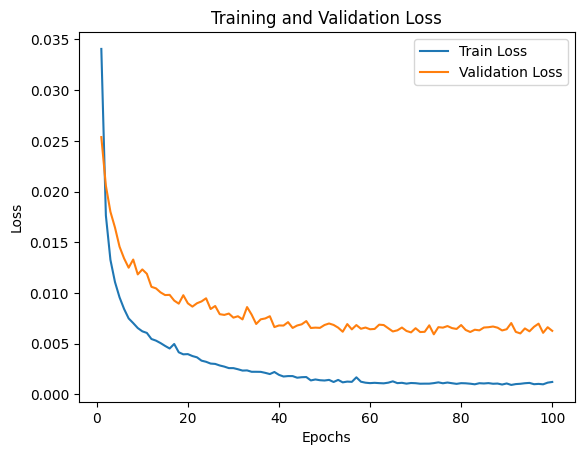

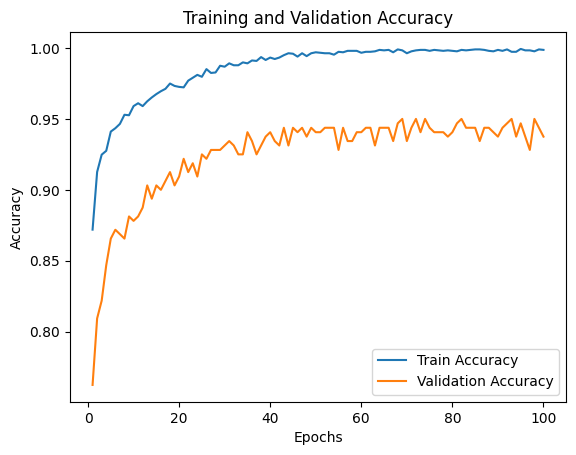

Final Training Accuracy: 0.9986449864498645
Final Validation Accuracy: 0.9375


In [27]:
use_cuda = True
model_resnet50_ANN=Classifier_ANN_resnet50()

if use_cuda and torch.cuda.is_available():
    model_resnet50_ANN.cuda()
    print('CUDA is available!  Training on GPU ...')
else:
    print('CUDA is not available.  Training on CPU ...')

batch_size  = 32
num_workers = 0
train(model_resnet50_ANN, data_Train_resnet50, data_Validation_resnet50, batch_size=32, lr=0.0001, num_epochs=100)

CUDA is available!  Training on GPU ...
Epoch 91: Train accuracy = 1.00, Train loss = 0.0006, Validation accuracy = 0.94, Validation loss = 0.0057
Epoch 92: Train accuracy = 1.00, Train loss = 0.0003, Validation accuracy = 0.95, Validation loss = 0.0049
Epoch 93: Train accuracy = 1.00, Train loss = 0.0003, Validation accuracy = 0.94, Validation loss = 0.0050
Epoch 94: Train accuracy = 1.00, Train loss = 0.0003, Validation accuracy = 0.95, Validation loss = 0.0050
Epoch 95: Train accuracy = 1.00, Train loss = 0.0003, Validation accuracy = 0.94, Validation loss = 0.0053
Epoch 96: Train accuracy = 1.00, Train loss = 0.0003, Validation accuracy = 0.94, Validation loss = 0.0055
Epoch 97: Train accuracy = 1.00, Train loss = 0.0003, Validation accuracy = 0.94, Validation loss = 0.0055
Epoch 98: Train accuracy = 1.00, Train loss = 0.0003, Validation accuracy = 0.94, Validation loss = 0.0056
Epoch 99: Train accuracy = 1.00, Train loss = 0.0004, Validation accuracy = 0.93, Validation loss = 0.00

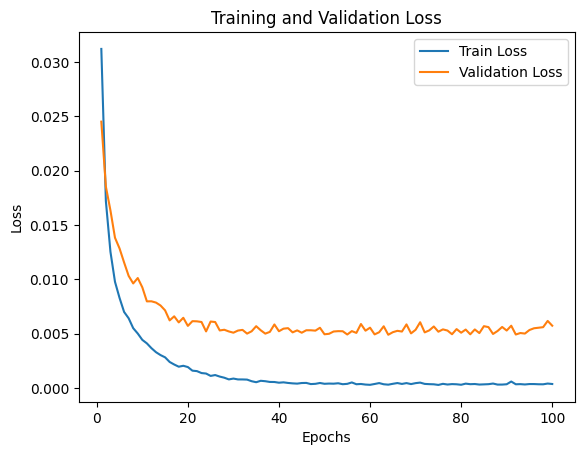

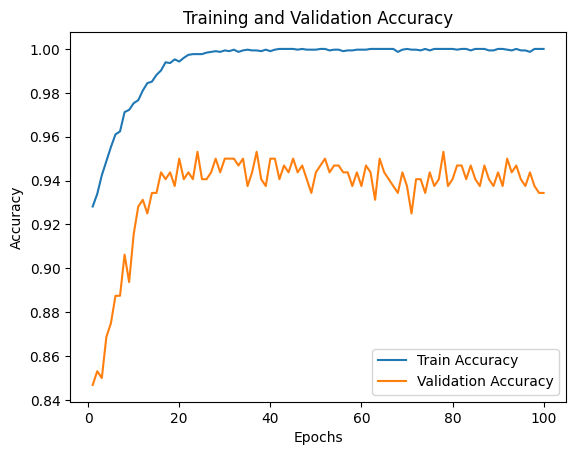

Final Training Accuracy: 1.0
Final Validation Accuracy: 0.934375


In [28]:
use_cuda = True
model_resnet50_CNN=Classifier_CNN_resnet50()

if use_cuda and torch.cuda.is_available():
    model_resnet50_CNN.cuda()
    print('CUDA is available!  Training on GPU ...')
else:
    print('CUDA is not available.  Training on CPU ...')

batch_size  = 32
num_workers = 0
train(model_resnet50_CNN, data_Train_resnet50, data_Validation_resnet50, batch_size=32, lr=0.0001, num_epochs=100)

## Train with RoadDamageCNN

CUDA is available!  Training on GPU ...
Epoch 91: Train accuracy = 0.93, Train loss = 0.2113, Validation accuracy = 0.87, Validation loss = 0.0060
Epoch 92: Train accuracy = 0.93, Train loss = 0.2117, Validation accuracy = 0.87, Validation loss = 0.0060
Epoch 93: Train accuracy = 0.93, Train loss = 0.2162, Validation accuracy = 0.87, Validation loss = 0.0059
Epoch 94: Train accuracy = 0.93, Train loss = 0.2152, Validation accuracy = 0.86, Validation loss = 0.0062
Epoch 95: Train accuracy = 0.93, Train loss = 0.2075, Validation accuracy = 0.87, Validation loss = 0.0060
Epoch 96: Train accuracy = 0.93, Train loss = 0.2084, Validation accuracy = 0.87, Validation loss = 0.0060
Epoch 97: Train accuracy = 0.93, Train loss = 0.2162, Validation accuracy = 0.87, Validation loss = 0.0061
Epoch 98: Train accuracy = 0.93, Train loss = 0.2163, Validation accuracy = 0.86, Validation loss = 0.0059
Epoch 99: Train accuracy = 0.93, Train loss = 0.2095, Validation accuracy = 0.87, Validation loss = 0.00

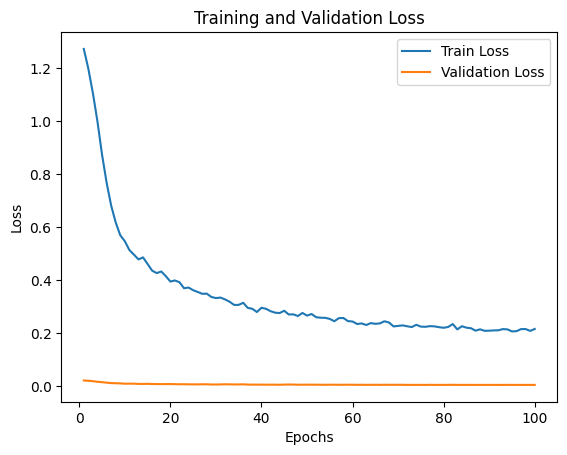

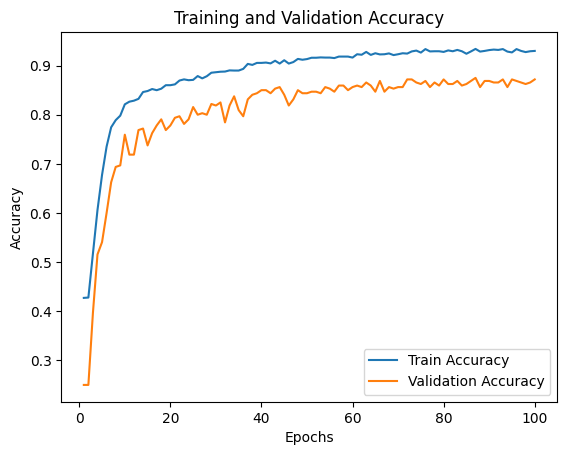

Final Training Accuracy: 0.9298780487804879
Final Validation Accuracy: 0.871875


In [29]:
def train_RoadDamageCNN(model, train_data, valid_data, batch_size, lr, num_epochs):
    
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                           num_workers=0, shuffle=True)
    val_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, 
                                          num_workers=0, shuffle=True)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

    # Adding a learning rate scheduler for plateau condition
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

    iters, train_loss, train_acc, val_acc, val_Loss, Epochs = [], [], [], [], [], []

    n = 0  # Number of iterations
    for epoch in range(num_epochs):
        n = 0
        total_train_loss = 0.0
        model.train()

        for imgs, labels in train_loader.dataset:
            # To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
                imgs = imgs.cuda()
                labels = labels.cuda()
            
            optimizer.zero_grad()
            
            out = model(imgs)
            loss = criterion(out, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            

            # Training loss for each batch
            total_train_loss += loss.item()
            n += 1

        # Average training loss
        Train_Loss = float(total_train_loss) / (len(train_loader.sampler))
        train_loss.append(Train_Loss)
        Epochs.append(epoch + 1)

        # Calculate training accuracy
        train_Acc = get_accuracy(model, train_loader.dataset)
        train_acc.append(train_Acc)

        # Set the model to evaluation mode for validation
        model.eval()
        val_Acc, val_loss = evaluate(model, val_loader.dataset)
        val_Loss.append(val_loss)
        val_acc.append(val_Acc)

        # Step the scheduler based on validation loss
        scheduler.step(val_loss)

        # printing last 10 epochs loss and accuracy for both Train and validation
        if epoch >= num_epochs - 10:
            print(f"Epoch {epoch + 1}: Train accuracy = {train_Acc:.2f}, Train loss = {Train_Loss:.4f}, "
                  f"Validation accuracy = {val_Acc:.2f}, Validation loss = {val_loss:.4f}")

    # Saving the model checkpoint to a file
    model_path = get_model_name(model.name, batch_size, lr, num_epochs - 1)
    torch.save(model.state_dict(), model_path)

    # Plotting the loss curves for training and validation
    plt.title("Training and Validation Loss")
    plt.plot(Epochs, train_loss, label="Train Loss")
    plt.plot(Epochs, val_Loss, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

    # Plotting the accuracy curves for training and validation
    plt.title("Training and Validation Accuracy")
    plt.plot(Epochs, train_acc, label="Train Accuracy")
    plt.plot(Epochs, val_acc, label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

use_cuda = True
model_RoadDamageCNN=RoadDamageCNN()

if use_cuda and torch.cuda.is_available():
    model_RoadDamageCNN.cuda()
    print('CUDA is available!  Training on GPU ...')
else:
    print('CUDA is not available.  Training on CPU ...')

batch_size  = 32
num_workers = 0
train_RoadDamageCNN(model_RoadDamageCNN, train_loader, validation_loader, batch_size=32, lr=0.0001, num_epochs=100)

In [30]:
# torch.save(model_RoadDamageCNN.state_dict(), 'model_RoadDamageCNN.pth')

## Evaluation

In [31]:
#loading the best model
model_alexnet_ANN=Classifier_ANN_Alexnet()
model_path_alexnet_ANN = get_model_name(model_alexnet_ANN.name, batch_size=32, learning_rate=0.0001, epoch=99)
state_alexnet_ANN = torch.load(model_path_alexnet_ANN)
model_alexnet_ANN.load_state_dict(state_alexnet_ANN)
# # calculating the test accuracy for our best model
use_cuda = True
if use_cuda and torch.cuda.is_available():
    model_alexnet_ANN.cuda()
    print('CUDA is available!  Training on GPU ...')
else:
    print('CUDA is not available.  Training on CPU ...')
test_loader_alexnet = torch.utils.data.DataLoader(data_test_alexnet, batch_size=32,
                                          num_workers=0, shuffle=True)
# accuracy, loss=evaluate(model_alexnet, test_loader_alexnet)
# print('The best test accuracy=',accuracy)

CUDA is available!  Training on GPU ...


/tmp/ipykernel_1789/1602473030.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_alexnet_ANN = torch.load(model_path_alexnet_ANN)


In [32]:
#loading the best model
model_alexnet_CNN=Classifier_CNN_Alexnet()
model_path_alexnet_CNN = get_model_name(model_alexnet_CNN.name, batch_size=32, learning_rate=0.0001, epoch=99)
state_alexnet_CNN = torch.load(model_path_alexnet_CNN)
model_alexnet_CNN.load_state_dict(state_alexnet_CNN)
# # calculating the test accuracy for our best model
use_cuda = True
if use_cuda and torch.cuda.is_available():
    model_alexnet_CNN.cuda()
    print('CUDA is available!  Training on GPU ...')
else:
    print('CUDA is not available.  Training on CPU ...')
test_loader_alexnet = torch.utils.data.DataLoader(data_test_alexnet, batch_size=32,
                                          num_workers=0, shuffle=True)
# accuracy, loss=evaluate(model_alexnet, test_loader_alexnet)
# print('The best test accuracy=',accuracy)

CUDA is available!  Training on GPU ...


/tmp/ipykernel_1789/881218225.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_alexnet_CNN = torch.load(model_path_alexnet_CNN)


In [33]:
model_vgg16_ANN = Classifier_ANN_vgg16()
model_path_vgg16_ANN = get_model_name(model_vgg16_ANN.name, batch_size=32, learning_rate=0.0001, epoch=99)
state_vgg16_ANN = torch.load(model_path_vgg16_ANN)
model_vgg16_ANN.load_state_dict(state_vgg16_ANN)
# calculating the test accuracy for our best model
use_cuda = True
if use_cuda and torch.cuda.is_available():
    model_vgg16_ANN.cuda()
    print('CUDA is available!  Training on GPU ...')
else:
    print('CUDA is not available.  Training on CPU ...')
test_loader_vgg16 = torch.utils.data.DataLoader(data_test_vgg16, batch_size=32,
                                          num_workers=0, shuffle=True)
#accuracy,loss=evaluate(model_vgg16,test_loader_vgg16)
#print('The best test accuracy=',accuracy)

CUDA is available!  Training on GPU ...


/tmp/ipykernel_1789/4072566914.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_vgg16_ANN = torch.load(model_path_vgg16_ANN)


In [34]:
model_vgg16_CNN = Classifier_CNN_vgg16()
model_path_vgg16_CNN = get_model_name(model_vgg16_CNN.name, batch_size=32, learning_rate=0.0001, epoch=99)
state_vgg16_CNN = torch.load(model_path_vgg16_CNN)
model_vgg16_CNN.load_state_dict(state_vgg16_CNN)
# calculating the test accuracy for our best model
use_cuda = True
if use_cuda and torch.cuda.is_available():
    model_vgg16_CNN.cuda()
    print('CUDA is available!  Training on GPU ...')
else:
    print('CUDA is not available.  Training on CPU ...')
test_loader_vgg16 = torch.utils.data.DataLoader(data_test_vgg16, batch_size=32,
                                          num_workers=0, shuffle=True)
#accuracy,loss=evaluate(model_vgg16,test_loader_vgg16)
#print('The best test accuracy=',accuracy)

CUDA is available!  Training on GPU ...


/tmp/ipykernel_1789/2573892978.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_vgg16_CNN = torch.load(model_path_vgg16_CNN)


In [35]:
model_resnet50_ANN = Classifier_ANN_resnet50()
model_path_resnet50_ANN = get_model_name(model_resnet50_ANN.name, batch_size=32, learning_rate=0.0001, epoch=99)
state_resnet50_ANN = torch.load(model_path_resnet50_ANN)
model_resnet50_ANN.load_state_dict(state_resnet50_ANN)
# calculating the test accuracy for our best model
use_cuda = True
if use_cuda and torch.cuda.is_available():
    model_resnet50_ANN.cuda()
    print('CUDA is available!  Training on GPU ...')
else:
    print('CUDA is not available.  Training on CPU ...')
test_loader_resnet50 = torch.utils.data.DataLoader(data_test_resnet50, batch_size=32,
                                          num_workers=0, shuffle=True)
#accuracy,loss=evaluate(model_resnet50, test_loader_resnet50)
#print('The best test accuracy=',accuracy)

CUDA is available!  Training on GPU ...


/tmp/ipykernel_1789/1391076006.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_resnet50_ANN = torch.load(model_path_resnet50_ANN)


In [36]:
model_resnet50_CNN = Classifier_CNN_resnet50()
model_path_resnet50_CNN = get_model_name(model_resnet50_CNN.name, batch_size=32, learning_rate=0.0001, epoch=99)
state_resnet50_CNN = torch.load(model_path_resnet50_CNN)
model_resnet50_CNN.load_state_dict(state_resnet50_CNN)
# calculating the test accuracy for our best model
use_cuda = True
if use_cuda and torch.cuda.is_available():
    model_resnet50_CNN.cuda()
    print('CUDA is available!  Training on GPU ...')
else:
    print('CUDA is not available.  Training on CPU ...')
test_loader_resnet50 = torch.utils.data.DataLoader(data_test_resnet50, batch_size=32,
                                          num_workers=0, shuffle=True)
#accuracy,loss=evaluate(model_resnet50, test_loader_resnet50)
#print('The best test accuracy=',accuracy)

/tmp/ipykernel_1789/434461847.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_resnet50_CNN = torch.load(model_path_resnet50_CNN)


CUDA is available!  Training on GPU ...


### Performance evaluation for resnet50

In [37]:
# Make predictions using the trained model
model_resnet50_ANN.eval()  # Set the model to evaluation mode
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader_resnet50:  # test_loader should contain your validation/test data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model_resnet50_ANN(inputs)

        # predicted class with the highest score
        _, predicted = torch.max(outputs, 1)

        # Append predictions and labels
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
# Accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f'Accuracy: {accuracy:.2f}')

# Precision, Recall, F1 Score
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')

# Confusion Matrix to calculate TPR and FPR
conf_matrix = confusion_matrix(all_labels, all_preds)
print('Confusion Matrix:')
print(conf_matrix)

# Calculate TPR and FPR for each class
for i in range(len(conf_matrix)):
    tp = conf_matrix[i, i]
    fn = sum(conf_matrix[i, :]) - tp
    fp = sum(conf_matrix[:, i]) - tp
    tn = conf_matrix.sum() - (tp + fp + fn)

    tpr = tp / (tp + fn) if (tp + fn) != 0 else 0  # True Positive Rate (Recall)
    fpr = fp / (fp + tn) if (fp + tn) != 0 else 0  # False Positive Rate

    print(f'Class {i} - TPR: {tpr:.2f}, FPR: {fpr:.2f}')

Accuracy: 0.85
Precision: 0.85
Recall: 0.85
F1 Score: 0.85
Confusion Matrix:
[[10  0  0  0]
 [ 0  7  3  0]
 [ 0  3  7  0]
 [ 0  0  0 10]]
Class 0 - TPR: 1.00, FPR: 0.00
Class 1 - TPR: 0.70, FPR: 0.10
Class 2 - TPR: 0.70, FPR: 0.10
Class 3 - TPR: 1.00, FPR: 0.00


In [38]:
# Make predictions using the trained model
model_resnet50_CNN.eval()  # Set the model to evaluation mode
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader_resnet50:  # test_loader should contain your validation/test data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model_resnet50_CNN(inputs)

        # predicted class with the highest score
        _, predicted = torch.max(outputs, 1)

        # Append predictions and labels
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
# Accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f'Accuracy: {accuracy:.2f}')

# Precision, Recall, F1 Score
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')

# Confusion Matrix to calculate TPR and FPR
conf_matrix = confusion_matrix(all_labels, all_preds)
print('Confusion Matrix:')
print(conf_matrix)

# Calculate TPR and FPR for each class
for i in range(len(conf_matrix)):
    tp = conf_matrix[i, i]
    fn = sum(conf_matrix[i, :]) - tp
    fp = sum(conf_matrix[:, i]) - tp
    tn = conf_matrix.sum() - (tp + fp + fn)

    tpr = tp / (tp + fn) if (tp + fn) != 0 else 0  # True Positive Rate (Recall)
    fpr = fp / (fp + tn) if (fp + tn) != 0 else 0  # False Positive Rate

    print(f'Class {i} - TPR: {tpr:.2f}, FPR: {fpr:.2f}')

Accuracy: 0.88
Precision: 0.88
Recall: 0.88
F1 Score: 0.87
Confusion Matrix:
[[10  0  0  0]
 [ 0  8  2  0]
 [ 0  3  7  0]
 [ 0  0  0 10]]
Class 0 - TPR: 1.00, FPR: 0.00
Class 1 - TPR: 0.80, FPR: 0.10
Class 2 - TPR: 0.70, FPR: 0.07
Class 3 - TPR: 1.00, FPR: 0.00


### Performance evaluation for vgg-16

In [39]:
# Make predictions using the trained model
model_vgg16_ANN.eval()  # Set the model to evaluation mode
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader_vgg16:  # test_loader should contain your validation/test data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model_vgg16_ANN(inputs)

        # predicted class with the highest score
        _, predicted = torch.max(outputs, 1)

        # Append predictions and labels
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
# Accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f'Accuracy: {accuracy:.2f}')

# Precision, Recall, F1 Score
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')

# Confusion Matrix to calculate TPR and FPR
conf_matrix = confusion_matrix(all_labels, all_preds)
print('Confusion Matrix:')
print(conf_matrix)

# Calculate TPR and FPR for each class
for i in range(len(conf_matrix)):
    tp = conf_matrix[i, i]
    fn = sum(conf_matrix[i, :]) - tp
    fp = sum(conf_matrix[:, i]) - tp
    tn = conf_matrix.sum() - (tp + fp + fn)

    tpr = tp / (tp + fn) if (tp + fn) != 0 else 0  # True Positive Rate (Recall)
    fpr = fp / (fp + tn) if (fp + tn) != 0 else 0  # False Positive Rate

    print(f'Class {i} - TPR: {tpr:.2f}, FPR: {fpr:.2f}')

Accuracy: 0.95
Precision: 0.96
Recall: 0.95
F1 Score: 0.95
Confusion Matrix:
[[10  0  0  0]
 [ 0 10  0  0]
 [ 0  2  8  0]
 [ 0  0  0 10]]
Class 0 - TPR: 1.00, FPR: 0.00
Class 1 - TPR: 1.00, FPR: 0.07
Class 2 - TPR: 0.80, FPR: 0.00
Class 3 - TPR: 1.00, FPR: 0.00


In [40]:
# Make predictions using the trained model
model_vgg16_CNN.eval()  # Set the model to evaluation mode
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader_vgg16:  # test_loader should contain your validation/test data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model_vgg16_CNN(inputs)

        # predicted class with the highest score
        _, predicted = torch.max(outputs, 1)

        # Append predictions and labels
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
# Accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f'Accuracy: {accuracy:.2f}')

# Precision, Recall, F1 Score
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')

# Confusion Matrix to calculate TPR and FPR
conf_matrix = confusion_matrix(all_labels, all_preds)
print('Confusion Matrix:')
print(conf_matrix)

# Calculate TPR and FPR for each class
for i in range(len(conf_matrix)):
    tp = conf_matrix[i, i]
    fn = sum(conf_matrix[i, :]) - tp
    fp = sum(conf_matrix[:, i]) - tp
    tn = conf_matrix.sum() - (tp + fp + fn)

    tpr = tp / (tp + fn) if (tp + fn) != 0 else 0  # True Positive Rate (Recall)
    fpr = fp / (fp + tn) if (fp + tn) != 0 else 0  # False Positive Rate

    print(f'Class {i} - TPR: {tpr:.2f}, FPR: {fpr:.2f}')

Accuracy: 0.93
Precision: 0.94
Recall: 0.93
F1 Score: 0.92
Confusion Matrix:
[[10  0  0  0]
 [ 0 10  0  0]
 [ 0  3  7  0]
 [ 0  0  0 10]]
Class 0 - TPR: 1.00, FPR: 0.00
Class 1 - TPR: 1.00, FPR: 0.10
Class 2 - TPR: 0.70, FPR: 0.00
Class 3 - TPR: 1.00, FPR: 0.00


### Performance evaluation for AlexNet

In [41]:
# Make predictions using the trained model
model_alexnet_ANN.eval()                        # Set the model to evaluation mode
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader_alexnet:  # test_loader should contain your validation/test data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model_alexnet_ANN(inputs)

        # predicted class with the highest score
        _, predicted = torch.max(outputs, 1)

        # Append predictions and labels
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
# Accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f'Accuracy: {accuracy:.2f}')

# Precision, Recall, F1 Score
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')

# Confusion Matrix to calculate TPR and FPR
conf_matrix = confusion_matrix(all_labels, all_preds)
print('Confusion Matrix:')
print(conf_matrix)

# Calculate TPR and FPR for each class
for i in range(len(conf_matrix)):
    tp = conf_matrix[i, i]
    fn = sum(conf_matrix[i, :]) - tp
    fp = sum(conf_matrix[:, i]) - tp
    tn = conf_matrix.sum() - (tp + fp + fn)

    tpr = tp / (tp + fn) if (tp + fn) != 0 else 0  # True Positive Rate (Recall)
    fpr = fp / (fp + tn) if (fp + tn) != 0 else 0  # False Positive Rate

    print(f'Class {i} - TPR: {tpr:.2f}, FPR: {fpr:.2f}')

Accuracy: 0.88
Precision: 0.89
Recall: 0.88
F1 Score: 0.87
Confusion Matrix:
[[10  0  0  0]
 [ 0  9  1  0]
 [ 0  4  6  0]
 [ 0  0  0 10]]
Class 0 - TPR: 1.00, FPR: 0.00
Class 1 - TPR: 0.90, FPR: 0.13
Class 2 - TPR: 0.60, FPR: 0.03
Class 3 - TPR: 1.00, FPR: 0.00


In [42]:
# Make predictions using the trained model
model_alexnet_CNN.eval()                        # Set the model to evaluation mode
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader_alexnet:  # test_loader should contain your validation/test data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model_alexnet_CNN(inputs)

        # predicted class with the highest score
        _, predicted = torch.max(outputs, 1)

        # Append predictions and labels
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
# Accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f'Accuracy: {accuracy:.2f}')

# Precision, Recall, F1 Score
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')

# Confusion Matrix to calculate TPR and FPR
conf_matrix = confusion_matrix(all_labels, all_preds)
print('Confusion Matrix:')
print(conf_matrix)

# Calculate TPR and FPR for each class
for i in range(len(conf_matrix)):
    tp = conf_matrix[i, i]
    fn = sum(conf_matrix[i, :]) - tp
    fp = sum(conf_matrix[:, i]) - tp
    tn = conf_matrix.sum() - (tp + fp + fn)

    tpr = tp / (tp + fn) if (tp + fn) != 0 else 0  # True Positive Rate (Recall)
    fpr = fp / (fp + tn) if (fp + tn) != 0 else 0  # False Positive Rate

    print(f'Class {i} - TPR: {tpr:.2f}, FPR: {fpr:.2f}')

Accuracy: 0.90
Precision: 0.93
Recall: 0.90
F1 Score: 0.90
Confusion Matrix:
[[10  0  0  0]
 [ 0 10  0  0]
 [ 0  4  6  0]
 [ 0  0  0 10]]
Class 0 - TPR: 1.00, FPR: 0.00
Class 1 - TPR: 1.00, FPR: 0.13
Class 2 - TPR: 0.60, FPR: 0.00
Class 3 - TPR: 1.00, FPR: 0.00


## Performance evaluation for RoadDamageCNN

In [43]:
# Make predictions using the trained model
model_RoadDamageCNN.eval()                        # Set the model to evaluation mode
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:  # test_loader should contain your validation/test data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model_RoadDamageCNN(inputs)

        # predicted class with the highest score
        _, predicted = torch.max(outputs, 1)

        # Append predictions and labels
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
# Accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f'Accuracy: {accuracy:.2f}')

# Precision, Recall, F1 Score
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')

# Confusion Matrix to calculate TPR and FPR
conf_matrix = confusion_matrix(all_labels, all_preds)
print('Confusion Matrix:')
print(conf_matrix)

# Calculate TPR and FPR for each class
for i in range(len(conf_matrix)):
    tp = conf_matrix[i, i]
    fn = sum(conf_matrix[i, :]) - tp
    fp = sum(conf_matrix[:, i]) - tp
    tn = conf_matrix.sum() - (tp + fp + fn)

    tpr = tp / (tp + fn) if (tp + fn) != 0 else 0  # True Positive Rate (Recall)
    fpr = fp / (fp + tn) if (fp + tn) != 0 else 0  # False Positive Rate

    print(f'Class {i} - TPR: {tpr:.2f}, FPR: {fpr:.2f}')

Accuracy: 0.85
Precision: 0.85
Recall: 0.85
F1 Score: 0.85
Confusion Matrix:
[[10  0  0  0]
 [ 0  8  1  1]
 [ 0  1  7  2]
 [ 0  0  1  9]]
Class 0 - TPR: 1.00, FPR: 0.00
Class 1 - TPR: 0.80, FPR: 0.03
Class 2 - TPR: 0.70, FPR: 0.07
Class 3 - TPR: 0.90, FPR: 0.10


## Confusion_matrix

In [44]:
def confusion_matrix_plot(model, data_loader, classes):

    model.eval()                     # Setting the model to evaluation mode
    all_preds = []
    all_labels = []

    # No requirement of gradient calculation for evaluation
    with torch.no_grad():
        for imgs, labels in data_loader:

            if use_cuda and torch.cuda.is_available():
                imgs = imgs.cuda()
                labels = labels.cuda()

            outputs = model(imgs)

            # Getting the predicted class with highest logit
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Computing confusion matrix
    c_m = confusion_matrix(all_labels, all_preds, labels=range(len(classes)))

    # Plotting confusion matrix using seaborn heatmap
    plt.figure(figsize=(6, 6))
    sns.heatmap(c_m, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    #plt.title('Confusion Matrix for Performance Visualization')
    plt.show()

### resnet50

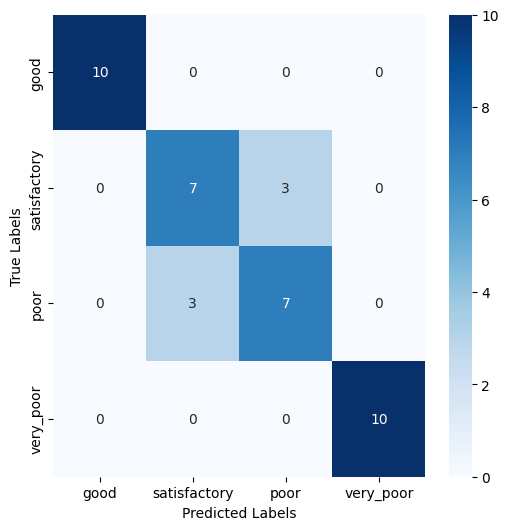

In [45]:
use_cuda = True
# Define the class names
classes = ['good', 'satisfactory', 'poor', 'very_poor']
confusion_matrix_plot(model_resnet50_ANN, test_loader_resnet50, classes)

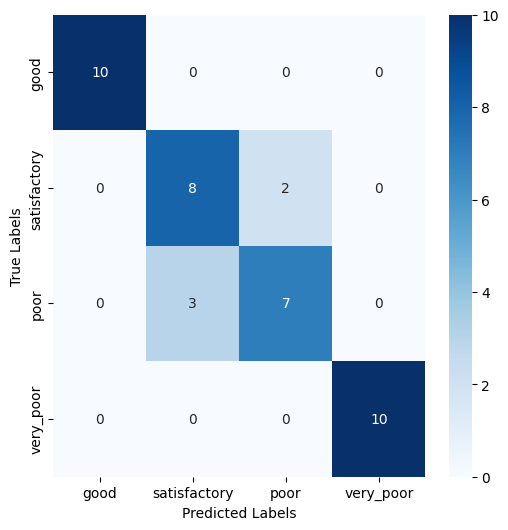

In [46]:
use_cuda = True
# Define the class names
classes = ['good', 'satisfactory', 'poor', 'very_poor']
confusion_matrix_plot(model_resnet50_CNN, test_loader_resnet50, classes)

### vgg16

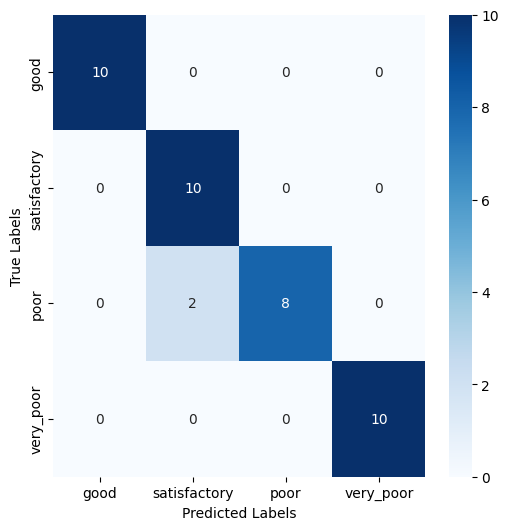

In [47]:
# Use CUDA if available
use_cuda = True
# Define the class names
classes = ['good','satisfactory', 'poor', 'very_poor']
confusion_matrix_plot(model_vgg16_ANN, test_loader_vgg16, classes)

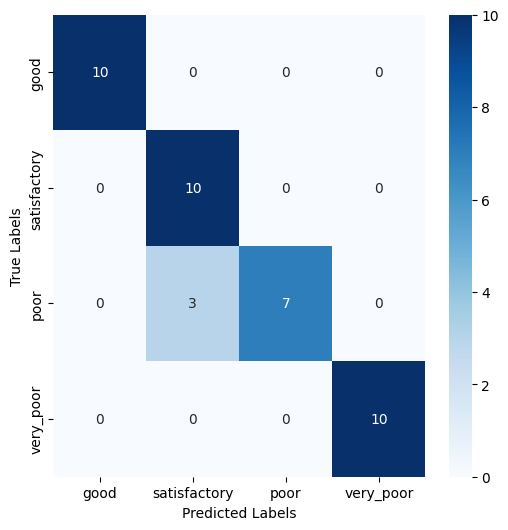

In [48]:
# Use CUDA if available
use_cuda = True
# Define the class names
classes = ['good', 'satisfactory', 'poor', 'very_poor']
confusion_matrix_plot(model_vgg16_CNN, test_loader_vgg16, classes)

### alexnet

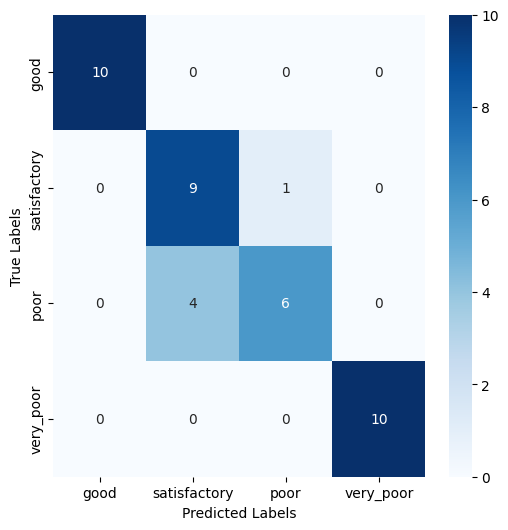

In [49]:
use_cuda = True
# Define the class names
classes = ['good', 'satisfactory', 'poor', 'very_poor']
confusion_matrix_plot(model_alexnet_ANN, test_loader_alexnet, classes)

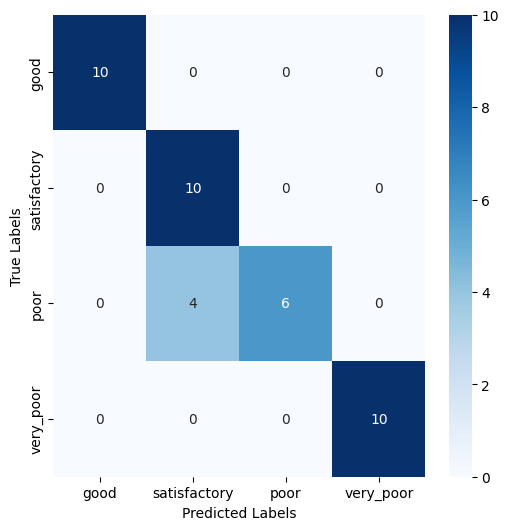

In [50]:
use_cuda = True
# Define the class names
classes = ['good', 'satisfactory', 'poor', 'very_poor']
confusion_matrix_plot(model_alexnet_CNN, test_loader_alexnet, classes)

## RoadDamageCNN

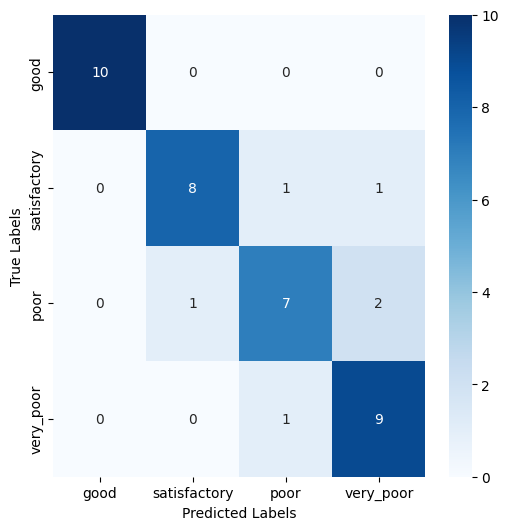

In [51]:
use_cuda = True
# Define the class names
classes = ['good', 'satisfactory', 'poor', 'very_poor']
confusion_matrix_plot(model_RoadDamageCNN, test_loader, classes)

# Qualitative results

From the confusion matrices, we can deduce that images labeled as very good and very poor are easily classified by all models. However, all models seem to make slight mistakes when it comes to classifying the satisfactory and poor classes. We suspect that this occurs because all models have constructed very distinct features for the good and very poor classes, yet the features for the satisfactory and poor classes are somewhat similar.

## Supplying Unseen Data to model (ANNs)

- As we wanted to see a greater distribution of image classification, we constructed a new testing dataset.
- This dataset was comprised of **40 images**. 20 images were taken from online and were estimated to be classified as either good or very poor. Another 20 photos were taken from the dataset of 555 images that had been shared with us.
- This new testing dataset was fed through each classification algorithm. As expected we saw more distributed predictions across all four classes. Primarily the images continued to be classified in the ‘satisfactory’ category although we saw more images classified in the ‘very poor’ category.

In [72]:
data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [73]:
#loading alex net model
model_alexnet = Classifier_ANN_Alexnet()
model_alexnet.load_state_dict(torch.load('model_Classifier_ANN_Alexnet_bs32_lr0.0001_epoch99', map_location=device, weights_only=True))
model_alexnet.to(device)
model_alexnet.eval()

Classifier_ANN_Alexnet(
  (fc1): Linear(in_features=9216, out_features=512, bias=True)
  (bn1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=256, out_features=4, bias=True)
)

In [76]:
import torchvision.models as models
alexnet = models.alexnet(pretrained=True)
alexnet.eval()

image_folder = '/workspace/data/unseen_images'

#empty list of tupples to save prediction for each image
predictions_alexnet = []
classes = ['good', 'satisfactory','poor', 'very_poor']
for image_name in os.listdir(image_folder):
    image_path = os.path.join(image_folder, image_name)

    if not image_name.lower().endswith(('.png', '.jpg', '.jpeg')):
        continue

    img = Image.open(image_path).convert('RGB')
    img_tensor = data_transform(img).unsqueeze(0)

    with torch.no_grad():
        features = alexnet.features(img_tensor)
        features = features.view(features.size(0), -1)
    features = features.to(device='cuda')

    with torch.no_grad():
        outputs = model_alexnet(features)

    _, predicted_class = torch.max(outputs, 1)
    predicted_class_name = classes[predicted_class.item()]

    predictions_alexnet.append((image_name, predicted_class_name))

for file_name, class_name in predictions_alexnet:
    print(f"Image: {file_name} | Predicted Class: {class_name}")


Image: medium_road_10.jpg | Predicted Class: satisfactory
Image: medium_road_17.jpg | Predicted Class: satisfactory
Image: medium_road_19.jpg | Predicted Class: satisfactory
Image: bad_road_3.jpg | Predicted Class: very_poor
Image: very_good_road_9.jpg | Predicted Class: satisfactory
Image: medium_road_3.jpg | Predicted Class: satisfactory
Image: medium_road_4.jpg | Predicted Class: satisfactory
Image: very_good_road_7.jpg | Predicted Class: satisfactory
Image: bad_road_8.png | Predicted Class: very_poor
Image: bad_road_4.jpeg | Predicted Class: very_poor
Image: bad_road_2.jpg | Predicted Class: very_poor
Image: bad_road_5.jpg | Predicted Class: very_poor
Image: medium_road_18.jpg | Predicted Class: satisfactory
Image: very_good_road_10.jpg | Predicted Class: poor
Image: bad_road_10.jpg | Predicted Class: very_poor
Image: medium_road_16.jpg | Predicted Class: satisfactory
Image: medium_road_11.jpg | Predicted Class: satisfactory
Image: medium_road_5.jpg | Predicted Class: satisfactory


In [77]:
class_counts = {class_name: 0 for class_name in classes}

for _, predicted_class_name in predictions_alexnet:
    class_counts[predicted_class_name] += 1

total_predictions = sum(class_counts.values())

class_percentages = {class_name: (count / total_predictions) * 100 for class_name, count in class_counts.items()}

print("Class Percentages:")
for class_name, percentage in class_percentages.items():
    print(f"{class_name}: {percentage:.2f}%")

Class Percentages:
good: 0.00%
satisfactory: 75.00%
poor: 2.50%
very_poor: 22.50%


In [74]:
#loading vgg model
model_vgg16 = Classifier_ANN_vgg16()
model_vgg16.load_state_dict(torch.load('model_Classifier_ANN_vgg16_bs32_lr0.0001_epoch99', map_location=device))
model_vgg16.to(device)
model_vgg16.eval()

/tmp/ipykernel_8176/1163662413.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_vgg16.load_state_dict(torch.load('model_Classifier_ANN_vgg16_bs32_lr0.0001_epoch99',

Classifier_ANN_vgg16(
  (fc1): Linear(in_features=25088, out_features=512, bias=True)
  (bn1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=256, out_features=4, bias=True)
)

In [78]:
import torchvision.models as models
vgg16 = models.vgg16(pretrained=True)
alexnet.eval()


predictions_vgg16 = []

for image_name in os.listdir(image_folder):
    image_path = os.path.join(image_folder, image_name)

    if not image_name.lower().endswith(('.png', '.jpg', '.jpeg')):
        continue

    img = Image.open(image_path).convert('RGB')
    img_tensor = data_transform(img).unsqueeze(0)

    with torch.no_grad():
        features = vgg16.features(img_tensor)
        features = features.view(features.size(0), -1)
    features = features.to(device='cuda')

    with torch.no_grad():
        outputs = model_vgg16(features)

    _, predicted_class = torch.max(outputs, 1)
    predicted_class_name = classes[predicted_class.item()]

    predictions_vgg16.append((image_name, predicted_class_name))

for file_name, class_name in predictions_vgg16:
    print(f"Image: {file_name} | Predicted Class: {class_name}")

Image: medium_road_10.jpg | Predicted Class: satisfactory
Image: medium_road_17.jpg | Predicted Class: satisfactory
Image: medium_road_19.jpg | Predicted Class: satisfactory
Image: bad_road_3.jpg | Predicted Class: very_poor
Image: very_good_road_9.jpg | Predicted Class: good
Image: medium_road_3.jpg | Predicted Class: satisfactory
Image: medium_road_4.jpg | Predicted Class: satisfactory
Image: very_good_road_7.jpg | Predicted Class: satisfactory
Image: bad_road_8.png | Predicted Class: very_poor
Image: bad_road_4.jpeg | Predicted Class: very_poor
Image: bad_road_2.jpg | Predicted Class: very_poor
Image: bad_road_5.jpg | Predicted Class: very_poor
Image: medium_road_18.jpg | Predicted Class: satisfactory
Image: very_good_road_10.jpg | Predicted Class: poor
Image: bad_road_10.jpg | Predicted Class: very_poor
Image: medium_road_16.jpg | Predicted Class: satisfactory
Image: medium_road_11.jpg | Predicted Class: satisfactory
Image: medium_road_5.jpg | Predicted Class: satisfactory
Image: v

In [79]:
class_counts = {class_name: 0 for class_name in classes}

for _, predicted_class_name in predictions_vgg16:
    class_counts[predicted_class_name] += 1

total_predictions = sum(class_counts.values())

class_percentages = {class_name: (count / total_predictions) * 100 for class_name, count in class_counts.items()}

print("Class Percentages:")
for class_name, percentage in class_percentages.items():
    print(f"{class_name}: {percentage:.2f}%")

Class Percentages:
good: 5.00%
satisfactory: 67.50%
poor: 2.50%
very_poor: 25.00%


In [75]:
#loading resnet50 model
model_resnet50 = Classifier_ANN_resnet50()
model_resnet50.load_state_dict(torch.load('model_Classifier_ANN_resnet50_bs32_lr0.0001_epoch99', map_location=device))
model_resnet50.to(device)
model_resnet50.eval()

/tmp/ipykernel_8176/1026696257.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_resnet50.load_state_dict(torch.load('model_Classifier_ANN_resnet50_bs32_lr0.0001_epo

Classifier_ANN_resnet50(
  (fc1): Linear(in_features=2048, out_features=512, bias=True)
  (bn1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=256, out_features=4, bias=True)
)

In [80]:
resnet50 = models.resnet50(pretrained=True)
resnet50.eval()


predictions_resnet50 = []

resnet50.to(device)
model_resnet50.to(device)

for image_name in os.listdir(image_folder):
    image_path = os.path.join(image_folder, image_name)

    if not image_name.lower().endswith(('.png', '.jpg', '.jpeg')):
        continue

    img = Image.open(image_path).convert('RGB')
    img_tensor = data_transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        backbone = torch.nn.Sequential(*list(resnet50.children())[:-1])
        features = backbone(img_tensor)
        features = features.view(features.size(0), -1)

    with torch.no_grad():
        outputs = model_resnet50(features)

    _, predicted_class = torch.max(outputs, 1)
    predicted_class_name = classes[predicted_class.item()]

    predictions_resnet50.append((image_name, predicted_class_name))

for file_name, class_name in predictions_resnet50:
    print(f"Image: {file_name} | Predicted Class: {class_name}")


Image: medium_road_10.jpg | Predicted Class: good
Image: medium_road_17.jpg | Predicted Class: good
Image: medium_road_19.jpg | Predicted Class: good
Image: bad_road_3.jpg | Predicted Class: good
Image: very_good_road_9.jpg | Predicted Class: good
Image: medium_road_3.jpg | Predicted Class: good
Image: medium_road_4.jpg | Predicted Class: good
Image: very_good_road_7.jpg | Predicted Class: good
Image: bad_road_8.png | Predicted Class: poor
Image: bad_road_4.jpeg | Predicted Class: very_poor
Image: bad_road_2.jpg | Predicted Class: very_poor
Image: bad_road_5.jpg | Predicted Class: good
Image: medium_road_18.jpg | Predicted Class: good
Image: very_good_road_10.jpg | Predicted Class: good
Image: bad_road_10.jpg | Predicted Class: very_poor
Image: medium_road_16.jpg | Predicted Class: good
Image: medium_road_11.jpg | Predicted Class: good
Image: medium_road_5.jpg | Predicted Class: good
Image: very_good_road_6.jpg | Predicted Class: good
Image: medium_road_2.jpg | Predicted Class: good
Im

In [81]:
class_counts = {class_name: 0 for class_name in classes}

for _, predicted_class_name in predictions_resnet50:
    class_counts[predicted_class_name] += 1

total_predictions = sum(class_counts.values())

class_percentages = {class_name: (count / total_predictions) * 100 for class_name, count in class_counts.items()}

print("Class Percentages:")
for class_name, percentage in class_percentages.items():
    print(f"{class_name}: {percentage:.2f}%")

Class Percentages:
good: 72.50%
satisfactory: 12.50%
poor: 2.50%
very_poor: 12.50%


## Supplying Unseen Data to model (CNNs)

In [82]:
from torchvision import models

classes = ['good', 'satisfactory','poor', 'very_poor']

alexnet_features = torch.nn.Sequential(*list(models.alexnet(pretrained=True).children())[:-1])  # Remove the classifier

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_alexnet = Classifier_CNN_Alexnet()
model_alexnet.load_state_dict(torch.load('model_Classifier_CNN_Alexnet_bs32_lr0.0001_epoch99'))
alexnet_features.to(device)
model_alexnet.to(device)

alexnet_features.eval()
model_alexnet.eval()


data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


image_folder = '/workspace/data/unseen_images'


predictions_cnn_alexnet = []

for image_name in os.listdir(image_folder):
    image_path = os.path.join(image_folder, image_name)

    if not image_name.lower().endswith(('.png', '.jpg', '.jpeg')):
        continue
    img = Image.open(image_path).convert('RGB')
    img_tensor = data_transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        features = alexnet_features(img_tensor)
        features = features.view(features.size(0), 256, 6, 6)

    with torch.no_grad():
        outputs = model_alexnet(features)
        _, predicted_class = torch.max(outputs, 1)
        predicted_class_name = classes[predicted_class.item()]

    predictions_cnn_alexnet.append((image_name, predicted_class_name))

for image_name, predicted_class_name in predictions_cnn_alexnet:
    print(f"Image: {image_name} | Predicted Class: {predicted_class_name}")

/tmp/ipykernel_8176/231522108.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_alexnet.load_state_dict(torch.load('model_Classifier_CNN_Alexnet_bs32_lr0.0001_epoch9

Image: medium_road_10.jpg | Predicted Class: satisfactory
Image: medium_road_17.jpg | Predicted Class: satisfactory
Image: medium_road_19.jpg | Predicted Class: satisfactory
Image: bad_road_3.jpg | Predicted Class: very_poor
Image: very_good_road_9.jpg | Predicted Class: satisfactory
Image: medium_road_3.jpg | Predicted Class: satisfactory
Image: medium_road_4.jpg | Predicted Class: satisfactory
Image: very_good_road_7.jpg | Predicted Class: satisfactory
Image: bad_road_8.png | Predicted Class: very_poor
Image: bad_road_4.jpeg | Predicted Class: very_poor
Image: bad_road_2.jpg | Predicted Class: very_poor
Image: bad_road_5.jpg | Predicted Class: very_poor
Image: medium_road_18.jpg | Predicted Class: satisfactory
Image: very_good_road_10.jpg | Predicted Class: poor
Image: bad_road_10.jpg | Predicted Class: very_poor
Image: medium_road_16.jpg | Predicted Class: satisfactory
Image: medium_road_11.jpg | Predicted Class: satisfactory
Image: medium_road_5.jpg | Predicted Class: satisfactory


In [83]:
class_counts = {class_name: 0 for class_name in classes}

for _, predicted_class_name in predictions_cnn_alexnet:
    class_counts[predicted_class_name] += 1

total_predictions = sum(class_counts.values())

class_percentages = {class_name: (count / total_predictions) * 100 for class_name, count in class_counts.items()}

print("Class Percentages:")
for class_name, percentage in class_percentages.items():
    print(f"{class_name}: {percentage:.2f}%")

Class Percentages:
good: 0.00%
satisfactory: 70.00%
poor: 5.00%
very_poor: 25.00%


In [84]:
classes = ['good', 'satisfactory','poor', 'very_poor']

resnet_features = torch.nn.Sequential(*list(models.resnet50(pretrained=True).children())[:-2])

global_avg_pool = torch.nn.AdaptiveAvgPool2d((1, 1))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_resnet50 = Classifier_CNN_resnet50()
model_resnet50.load_state_dict(torch.load('model_Classifier_CNN_resnet50_bs32_lr0.0001_epoch99'))
resnet_features.to(device)
global_avg_pool.to(device)
model_resnet50.to(device)

resnet_features.eval()
global_avg_pool.eval()
model_resnet50.eval()

data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

image_folder = '/workspace/data/unseen_images'

predictions_cnn_resnet50 = []

for image_name in os.listdir(image_folder):
    image_path = os.path.join(image_folder, image_name)

    if not image_name.lower().endswith(('.png', '.jpg', '.jpeg')):
        continue

    img = Image.open(image_path).convert('RGB')
    img_tensor = data_transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        features = resnet_features(img_tensor)
        features = global_avg_pool(features)

    with torch.no_grad():
        outputs = model_resnet50(features)
        _, predicted_class = torch.max(outputs, 1)
        predicted_class_name = classes[predicted_class.item()]

    predictions_cnn_resnet50.append((image_name, predicted_class_name))

for image_name, predicted_class_name in predictions_cnn_resnet50:
    print(f"Image: {image_name} | Predicted Class: {predicted_class_name}")

/tmp/ipykernel_8176/2698731803.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_resnet50.load_state_dict(torch.load('model_Classifier_CNN_resnet50_bs32_lr0.0001_epo

Image: medium_road_10.jpg | Predicted Class: good
Image: medium_road_17.jpg | Predicted Class: good
Image: medium_road_19.jpg | Predicted Class: good
Image: bad_road_3.jpg | Predicted Class: good
Image: very_good_road_9.jpg | Predicted Class: good
Image: medium_road_3.jpg | Predicted Class: good
Image: medium_road_4.jpg | Predicted Class: good
Image: very_good_road_7.jpg | Predicted Class: poor
Image: bad_road_8.png | Predicted Class: poor
Image: bad_road_4.jpeg | Predicted Class: very_poor
Image: bad_road_2.jpg | Predicted Class: very_poor
Image: bad_road_5.jpg | Predicted Class: good
Image: medium_road_18.jpg | Predicted Class: good
Image: very_good_road_10.jpg | Predicted Class: poor
Image: bad_road_10.jpg | Predicted Class: very_poor
Image: medium_road_16.jpg | Predicted Class: good
Image: medium_road_11.jpg | Predicted Class: good
Image: medium_road_5.jpg | Predicted Class: good
Image: very_good_road_6.jpg | Predicted Class: good
Image: medium_road_2.jpg | Predicted Class: good
Im

In [85]:
class_counts = {class_name: 0 for class_name in classes}

for _, predicted_class_name in predictions_cnn_resnet50:
    class_counts[predicted_class_name] += 1

total_predictions = sum(class_counts.values())

class_percentages = {class_name: (count / total_predictions) * 100 for class_name, count in class_counts.items()}

print("Class Percentages:")
for class_name, percentage in class_percentages.items():
    print(f"{class_name}: {percentage:.2f}%")

Class Percentages:
good: 72.50%
satisfactory: 5.00%
poor: 7.50%
very_poor: 15.00%


In [86]:
classes = ['good', 'satisfactory','poor', 'very_poor']
vgg16_features = torch.nn.Sequential(*list(models.vgg16(pretrained=True).features))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_vgg16 = Classifier_CNN_vgg16()
model_vgg16.load_state_dict(torch.load('model_Classifier_CNN_vgg16_bs32_lr0.0001_epoch99'))
vgg16_features.to(device)
model_vgg16.to(device)

vgg16_features.eval()
model_vgg16.eval()

data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

image_folder = '/workspace/data/unseen_images'

predictions_cnn_vgg16 = []

for image_name in os.listdir(image_folder):
    image_path = os.path.join(image_folder, image_name)

    if not image_name.lower().endswith(('.png', '.jpg', '.jpeg')):
        continue

    img = Image.open(image_path).convert('RGB')
    img_tensor = data_transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        features = vgg16_features(img_tensor)

    with torch.no_grad():
        outputs = model_vgg16(features)
        _, predicted_class = torch.max(outputs, 1)
        predicted_class_name = classes[predicted_class.item()]

    predictions_cnn_vgg16.append((image_name, predicted_class_name))

for image_name, predicted_class_name in predictions_cnn_vgg16:
    print(f"Image: {image_name} | Predicted Class: {predicted_class_name}")

/tmp/ipykernel_8176/1629994991.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_vgg16.load_state_dict(torch.load('model_Classifier_CNN_vgg16_bs32_lr0.0001_epoch99')

Image: medium_road_10.jpg | Predicted Class: satisfactory
Image: medium_road_17.jpg | Predicted Class: satisfactory
Image: medium_road_19.jpg | Predicted Class: satisfactory
Image: bad_road_3.jpg | Predicted Class: very_poor
Image: very_good_road_9.jpg | Predicted Class: satisfactory
Image: medium_road_3.jpg | Predicted Class: satisfactory
Image: medium_road_4.jpg | Predicted Class: satisfactory
Image: very_good_road_7.jpg | Predicted Class: satisfactory
Image: bad_road_8.png | Predicted Class: very_poor
Image: bad_road_4.jpeg | Predicted Class: very_poor
Image: bad_road_2.jpg | Predicted Class: very_poor
Image: bad_road_5.jpg | Predicted Class: very_poor
Image: medium_road_18.jpg | Predicted Class: satisfactory
Image: very_good_road_10.jpg | Predicted Class: poor
Image: bad_road_10.jpg | Predicted Class: very_poor
Image: medium_road_16.jpg | Predicted Class: satisfactory
Image: medium_road_11.jpg | Predicted Class: satisfactory
Image: medium_road_5.jpg | Predicted Class: satisfactory


In [87]:
class_counts = {class_name: 0 for class_name in classes}

for _, predicted_class_name in predictions_cnn_resnet50:
    class_counts[predicted_class_name] += 1

total_predictions = sum(class_counts.values())

class_percentages = {class_name: (count / total_predictions) * 100 for class_name, count in class_counts.items()}

print("Class Percentages:")
for class_name, percentage in class_percentages.items():
    print(f"{class_name}: {percentage:.2f}%")

Class Percentages:
good: 72.50%
satisfactory: 5.00%
poor: 7.50%
very_poor: 15.00%


# Conclusion

In summary, this project outlines all the steps necessary to construct an effective neural network image classifier to distinguish road qualities. This project was able to improve upon existing work by significantly increasing the size of the training dataset. 
- Of all the models that were tested, the **VGG-16 model with ANN classification** achieved the greatest accuracy, precision, recall, and F1 score.
- All models mildly misclassified images from the satisfactory and poor categories. For future work, we suggest reducing the number of classes from four to three by removing the ‘poor’ class.
- By addressing the model's weaknesses in distinguishing between features of the ‘satisfactory’ and ‘poor’ classes, future iterations of this project could achieve even higher performance metrics.

# References